In [139]:
import csv
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#load and organize the data
employeeData=pd.read_csv('employee_retention_data.csv')
employeeData.head()
day1=pd.to_datetime('2011-01-23')
employeeData['join_date']=pd.to_datetime(employeeData['join_date'])
employeeData['quit_date']=pd.to_datetime(employeeData['quit_date'])
employeeData['firstDay']=employeeData['join_date']-day1
employeeData['lastDay']=employeeData['quit_date']-day1
employeeData['firstDay']=employeeData['firstDay'].astype('timedelta64[D]')
employeeData['lastDay']=employeeData['lastDay'].astype('timedelta64[D]')
#replace nans for people still employed at company with 0 for boolean quit/noquit, 2000 for linear regression
employeeData['lastDay']=employeeData['lastDay'].fillna(2000)
employeeData.head()
employeeData['firstDay']=map(lambda x: int(x), employeeData['firstDay'])
employeeData['lastDay']=map(lambda x: int(x), employeeData['lastDay'])
employeeData['jobLength']=employeeData['lastDay']-employeeData['firstDay']
employeeData['quitBool']=employeeData['lastDay']>0

In [22]:
#takes a long time
maxworkdays=int(max(employeeData['lastDay']))
daylist=[]
headcount=[]
companyid=[]
for cID in list(set(employeeData.company_id)):
    for numWorkDays in range(1,maxworkdays+1):
        daylist.append(numWorkDays)
        companyid.append(cID)
        headcount.append(sum((employeeData['company_id']==cID) & (employeeData['firstDay']<=numWorkDays) & 
                             (employeeData['lastDay']>=numWorkDays)))

empRetention = pd.DataFrame({'day': daylist,'employee_headcount': headcount,'company_id': companyid})


In [158]:

from sklearn import datasets
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import RepeatedKFold
X=employeeData[['seniority','salary']] #having company ID in here doesn't help
Y=employeeData['quitBool'] #for logistic regression
Y=employeeData['jobLength'] #for linear regression

rkf = RepeatedKFold(n_splits=5, n_repeats=10)

logreg = LogisticRegression(C=1.,penalty='l2',tol=0.0001)
linreg = LinearRegression()
accuracy=[]
coefs=[]
for train_index, test_index in rkf.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    Y_train, Y_test = Y.loc[train_index], Y.loc[test_index]
    Y_pred = linreg.fit(X_train, Y_train).predict(X_test)
    accuracy.append(float((Y_test == Y_pred).sum())/float(len(Y_test)))
    coefs.append(linreg.coef_)
    
print ('accuracy of %2.1f +/- %2.1f percent' %(np.mean(accuracy)*100,np.std(accuracy)*100))

accuracy of 0.0 +/- 0.0 percent


## Results
54% accuracy with logistic regression, similar for support vector classifier, no significant r^2 for linear regression. However, there do seem to be clusters within the data that show different trends - perhaps an HDBSCAN or other clustering algo could sort that out. Perhaps 3 clusters below, one of which lies roughly along the unity line, suggesting that seniority and salary offer predictability of time in the position for those people. Other two: variability not predicted by regressors, and more variability predicted by regressors than should have been. More data about the finances/profitability of the company would perhaps help to tease out these retention trends.

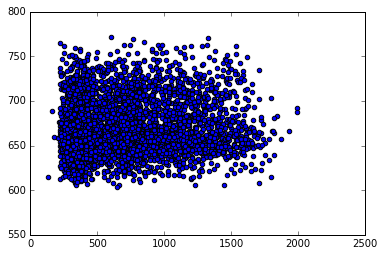

array([[ 1.        ,  0.05966853],
       [ 0.05966853,  1.        ]])

In [160]:
plt.scatter(Y_test,Y_pred)
plt.show()
np.corrcoef(Y_test,Y_pred)